## The vanilla RBM.

   * weights $W_{ji}$ means the weight between the j-th hidden unit and the i-th visible unit.
   * $W_{0i}$ is "bias" into the i-th visible unit. 
   * $W_{j0}$ is "bias" into the j-th hidden unit. 
The joint probability under the RBM factorisation is:
$$ P^\star(h,v) = \prod_i \prod_j e^{h_j W_{ji} v_i} \;\; \times \;\; \prod_{i^\prime} e^{W_{0i^\prime} v_{i^\prime}} \;\; \times \;\; \prod_{j^\prime} e^{W_{j^\prime 0} h_{j^\prime}} $$
and its logarithm is
$$ \log P^\star(h,v) = \sum_i  \sum_j h_j W_{ji} v_i \;\; + \;\; \sum_i W_{0i} v_i \;\; + \;\; \sum_j W_{j0} h_j $$

## Gibbs in vanilla RBM
To sample from this distribution we can figure out the Gibbs update step. 

The probability $p(h_j=1|v)$ that the j-th hidden unit generates a 1 can be written as $ \sigma(\psi_j) $ with $\sigma(x)=1/(1+e^{-x})$ and $\psi_j = \log P^*(h,v | h_j =1 ) - \log P^*(h,v | h_j = 0)$. 
And from the $\log P^\star(h,v)$ given above, this is easily seen to be
$ \psi_j(v) = \sum_i W_{ji} v_i + W_{j0}$

Similarly, for the visible units the probability $p(v_i=1|h)$ that the i-th visible generates a 1 can be written as 
$\sigma(\phi_i(h)) $ with $\phi_i(h) = \log P^*(h,v | v_i =1 ) - \log P^*(h,v | v_i = 0)$. 
And similarly this can be seen to be
$ \phi_i(h) = \sum_j W_{ji} h_j + W_{0i}$ for the i-th visible unit.


For convenience we will sometimes write $\sigma(\phi_i(h))$ as just $\sigma_i(h)$.

## Gibbs in an equivalent network

Note this is equivalent to a 3 layer network in which the top 2 layers form an RBM and the lower one is a sigmoid belief network. 
Sampling from the latter model involves drawing Bernoulli variables repeatedly (eg. via alternating Gibbs sampling) from the RBM until equilibrium and then sampling $v$ from the visibles given the hiddens $h$, ie. "ancestral sampling" in the belief net, but from an $h$ generated by an RBM. 

We know (from above) how to generate the $h$ sample: Gibbs sampling from the RBM will do it. Then, the conditional probability of $v$ under a sigmoid belief net is (by definition) $p(v_i=1|h) = \sigma_i(h)$. 
Thus _Gibbs sampling from a simple RBM ending in a sample for $v$ is the same as sampling $h$ from the same RBM and then using a sigmoid belief net for the last step_.  

However, there's another way to draw such samples. Write (product rule) $\log P^\star(h,v) = \log P^\star(h) + \log P(v|h)$. We have the second term already:
$$ \log P(v|h) = \sum_i v_i \log \sigma_i(h) + (1-v_i) \log (1 - \sigma_i(h)$$

To find $P^\star(h)$ we need to marginalise that joint over all $\mathbf{v}$ configurations:
$$\begin{align} P^\star(h) &= \sum_{v_1=0}^1 \cdots \sum_{v_n=0}^1 \exp \bigg[  \log P^{\star}(h,v) \bigg] \\
&= \sum_{v_1=0}^1 \cdots \sum_{v_n=0}^1 \exp \bigg[  \sum_i  \sum_j h_j W_{ji} v_i \;\; + \;\; \sum_i W_{0i} v_i \;\; + \;\; \sum_j W_{j0} h_j \bigg] \\
&= \sum_{v_1=0}^1 \cdots \sum_{v_n=0}^1 \exp \bigg[  \sum_i v_i \phi_i(h)  \;\; + \;\; \sum_j W_{j0} h_j \bigg] \\
\text{where } \phi_i(h) &= \sum_j W_{ji} h_j + W_{0i} \\
&= \exp\left[ \sum_j h_j  W_{j0} \right] \;\; \times \sum_{v_1=0}^1 \cdots \sum_{v_n=0}^1 \prod_i \exp\bigg[ v_i \phi_i(h) \bigg] \\
&= \exp\left[\sum_j h_j  W_{j0}\right] \;\; \times \prod_i \bigg( 1 + e^{\phi_i(h) } \bigg) \\
\text{and so}
\log P^\star(h) &= \sum_j h_j  W_{j0} \;\; +  \sum_i \log \bigg( 1 + e^{\phi_i(h) } \bigg)
\\
&= \sum_j h_j  W_{j0} \;\; + \; \sum_i \phi_i(h) \;  - \; \sum_i \log \sigma_i(h) 
\end{align} $$

So far we've figured out $\log P^\star(h)$ for the RBM that is the "top layer".

Therefore another way to write $\log P^\star(h,v)$ is
$$ 
\log P^\star(h,v) = \underbrace{\sum_j h_j  W_{j0} \;\; + \; \sum_i \phi_i(h) \;  - \; \sum_i \log \sigma_i(h)}_{\log P^\star(h)} \;\;+\;\; \underbrace{\sum_i v_i \log \sigma_i(h) + (1-v_i) \log (1 - \sigma_i(h))}_{\log P(v \mid h)} 
$$
By collecting terms and simplifying one can readily those that this matches the earlier form.

# a model of two causes

Now we'd like to change this slightly, so that 2 RBMs that are independent are used to model two causes, which are then combined at the last moment via a sigmoid belief net to form $v$.
Suppose that at a given moment the 2nd RBM is in a state which contributes an extra activation $\epsilon_i$ respectively to each of the visible units. We're interested in how this will affect the Gibbs updates to the hidden units $h$ in the first RBM.

Note: $\epsilon_i$ is in general going to be a weighted sum of inputs from the second RBM's hidden layer, _plus a new bias_ arising from the second RBM. Although the two biases both going into the visible units seems (and might be) redundant, in the generative model it seems sensible that visible activations under the two "causes" would have different background rates if taken separately (ie. different biases). So for now I think we should leave them in, but maybe hope to eliminate / merge if possible in future, if it helps anything...

Before going on to the Gibbs Sampler version in which visible units are clampled, consider "ancestral" sampling from the model: each RBM independently does alternating Gibbs Sampling for a (longish) period, and then both combine to generate a sample $v$ vector, by adding both their weighted sums ($\phi$) _and adding in both their visible biases too_ . That's a much more efficient way to do the "sleep" phase than doing what follows (which is mandatory for the "wake" phase samples however).

The Gibbs update step is given by $p_j = \sigma(\phi_j) $ with 
$ \psi_j = \log P^*(h,v ; h_j =1 ) - \log P^*(h,v ; h_j = 0)$.
However this time we don't have exact correspondence with an RBM because only the final step involves $\epsilon$, not the reverberations in the RBM above it that generates $h$. So it's not enough to consider just the RBM alone, with it's joint being just the product of factors in the first line of math above. We need to incorporate the last step explicitly, with its slight difference in the form of $\epsilon$. We know the joint decomposes into this:
$$ \log P^* (h,v) = \log P^*(h) + \log P(v|h)$$
where the first term is the vanilla RBM probability but the second is the final layer's probability, now given by
$$ \log P(v|h,\epsilon) = \sum_i v_i \log \sigma (\phi_i(h) + \epsilon_i) + (1-v_i) \log (1 - \sigma(\phi_i(h) + \epsilon_i)$$ 

To carry out Gibbs sampling in the hidden layer of this architecture we need to calculate $\psi_j = \log P^*(h,v ; h_j =1 ) - \log P^*(h,v ; h_j = 0)$. Using the fact that $\phi_i(h ; h_j=1) = \phi_i(h ; h_j=0) + W_{ji}$, and abbreviating $\phi_i(h ; h_j=0)$ to $\phi_i^0$, we obtain

$$\psi_j = \sum_i v_i \log \left( \frac{1+ e^{-\phi_i^0 - \epsilon_i}}{1+e^{-\phi_i^0 - W_{ji} -\epsilon_i}} \frac{1+ e^{\phi_i^0 + W_{ji} + \epsilon}}{1+e^{\phi_i^0 + \epsilon_i}}\right) \;\;+ \;\;\sum_i \log \left(\frac{1+e^{\phi_i^0 + W_{ji}}}{1+ e^{\phi_i^0}}
\frac{1+e^{\phi_i^0 + \epsilon_i}}{1+ e^{\phi_i^0 + W_{ji} + \epsilon_i}} \right)$$

Now $\phi = \log \frac{1+e^{\phi}}{1+e^{-\phi}}$ (Marcus' magic identity), which is$ = \log \frac{\sigma(\phi)}{\sigma(-\phi)}$.
So the first term simplifies to
$ \sum_i v_i W_{ji}$, which is the same as that in a "vanilla RBM".

The second term can also be simplified, using the identity $\log(1-\sigma(\phi)) = \phi - \log(1+e^\phi)$.

This leads to the following Gibbs Sampler probability of the j-th hidden unit being 1: $p_j = \sigma(\psi_j)$ with

$$\psi_j = \sum_i (W_{ji} v_i + C_{ji}) $$
where
$$C_{ji} \; = \;\log \bigg[ \frac{\sigma (\phi_i^0)}{\sigma (\phi_i^0 + W_{ji})} . \frac{\sigma (\phi_i^0 + W_{ji} + \epsilon_i) }{\sigma (\phi_i^0 + \epsilon_i)} \bigg] $$

Note that $\sum_i C_{ji}$ can be thought of as correction to vanilla RBM Gibbs "input" to the hidden node. Weirdly, $v$ plays no role in the $C$ term!

Written another way this is
$$C_{ji} = \log \sigma(\phi_i^0)  \; +\log \sigma (\phi_i^0 + W_{ji} + \epsilon_i) \;- \log \sigma (\phi_i^0 + W_{ji})  \;- \log \sigma ( \phi_i^0  + \epsilon _i) $$

It is clear that adding the single $\epsilon$ has introduced a dependency between the whole of $h$, which is a worry.

1) What happens if $\epsilon$ feeds into $u$ as well?
2) How coupled is it really?
3) Can we just hack it?
    a) Conditionals on the size of $\phi$, $\epsilon$
    b) Truncated Markov chain
4) Linear RBM
5) Is any hidden node coupling bad?
6) How to interpret as Blind Source Separation

## What does the correction to standard RBM $\psi$ look like?

Thought: the "correction" is all hinge functions and should have an approximation as "if../else.." piecewise linear regimes, and this ought to have an intuitive hand-wave type explanation that makes sense.

So let's plot the correction contours on axes $\epsilon_i$ versus $\phi_i$, for (say) a positive $w_{ij}$.
We'll need two plots for the two cases $h_i=0,1$

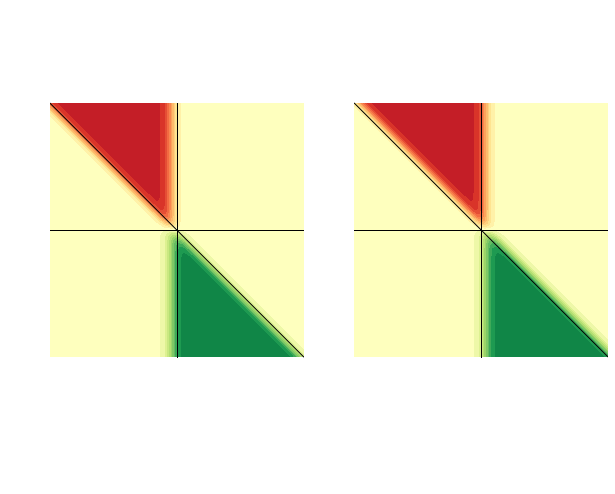

In [2]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy.random as rng
np.set_printoptions(precision = 2)
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def calc_psi_correction(phi, eps, w,h):
    # note here the Phi is the full weighted sum into the visible node. We're explicitly taking care of the hidden activation too. 
    correction = np.log(sigmoid(phi+w+eps-h*w)) + np.log( sigmoid(phi-h*w)) - np.log( sigmoid(phi+w-h*w)) - np.log( sigmoid(phi+eps-h*w)) 
    return correction

def calc_psi0_correction(phi0, eps, w):
    # note here the phi0 is what the weighted sum into the visible node WOULD be IF h=0. 
    correction = np.log(sigmoid(phi0+w+eps)) + np.log( sigmoid(phi0)) - np.log( sigmoid(phi0+w)) - np.log( sigmoid(phi0+eps)) 
    return correction

reach = 40
phi, eps = np.mgrid[-reach:reach:100j, -reach:reach:100j]
wgt = 3.0
levels = np.arange(-abs(wgt)-0.5, abs(wgt)+0.5, abs(wgt)/10.)
cmap = cm.RdYlGn

plt.subplot(121)
psi_correction_h0 = calc_psi_correction(phi, eps, wgt, 0)
C = plt.contourf(phi, eps, psi_correction_h0, levels, origin='lower', cmap=cm.get_cmap(cmap, len(levels)-1))
#plt.colorbar()
#plt.title('$h_j=0$')
plt.xlabel('$\phi_i$ (left network)')
plt.ylabel('$\phi_i$ (right network)')
plt.plot([0,0], [-reach, reach],'-k', [-reach, reach], [0,0], '-k', [-reach, reach], [reach,-reach], '-k')
plt.axis([-reach, reach, -reach, reach])
plt.axis('off')
plt.axis('equal')
plt.xticks([-reach/2,reach/2])
plt.yticks([-reach/2,reach/2])

plt.subplot(122)
psi_correction_h0 = calc_psi_correction(phi, eps, wgt, 1)
#plt.title('$h_j=1$')
C = plt.contourf(phi, eps, psi_correction_h0, levels, origin='lower', cmap=cm.get_cmap(cmap, len(levels)-1))
plt.plot([0,0], [-reach, reach],'-k', [-reach, reach], [0,0], '-k', [-reach, reach], [reach,-reach], '-k')
plt.axis('off')
plt.axis('equal')
plt.xticks([-reach/2,reach/2])
plt.yticks([-reach/2,reach/2])

plt.savefig('correction.png', dpi=200)

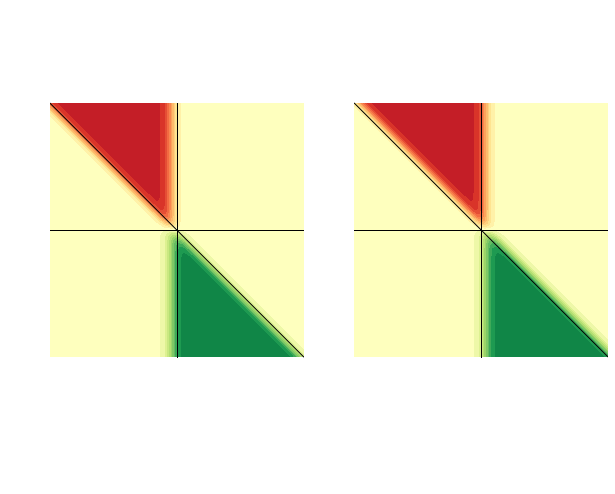

In [3]:
def calc_APPROX_psi_correction(phi, eps, w, h):
    # note here the Phi is the full weighted sum into the visible node. We're explicitly taking care of the hidden activation too. 
    correction = np.log(sigmoid(phi+w+eps-h*w)) + np.log( sigmoid(phi-h*w)) - np.log( sigmoid(phi+w-h*w)) - np.log( sigmoid(phi+eps-h*w)) 
    return correction

plt.subplot(121)
psi_correction_h0 = calc_APPROX_psi_correction(phi, eps, wgt, 0)
C = plt.contourf(phi, eps, psi_correction_h0, levels, origin='lower', cmap=cm.get_cmap(cmap, len(levels)-1))
#plt.colorbar()
#plt.title('$h_j=0$')
plt.xlabel('$\phi_i$ (left network)')
plt.ylabel('$\phi_i$ (right network)')
plt.plot([0,0], [-reach, reach],'-k', [-reach, reach], [0,0], '-k', [-reach, reach], [reach,-reach], '-k')
plt.axis([-reach, reach, -reach, reach])
plt.axis('off')
plt.axis('equal')
plt.xticks([-reach/2,reach/2])
plt.yticks([-reach/2,reach/2])

plt.subplot(122)
psi_correction_h0 = calc_psi_correction(phi, eps, wgt, 1)
#plt.title('$h_j=1$')
C = plt.contourf(phi, eps, psi_correction_h0, levels, origin='lower', cmap=cm.get_cmap(cmap, len(levels)-1))
plt.plot([0,0], [-reach, reach],'-k', [-reach, reach], [0,0], '-k', [-reach, reach], [reach,-reach], '-k')
plt.axis('off')
plt.axis('equal')
plt.xticks([-reach/2,reach/2])
plt.yticks([-reach/2,reach/2])

plt.savefig('correction.png', dpi=200)

# Approximations (trying to find a simple one)
Within its "wedges" the correction is pretty much flat, so an approximation is just to compute true/false on the appropriate condition. The red section is where v is ON under full input from both nets, but would be OFF if it were the first alone. It's fairly closely approximated by $\sigma(\phi+\epsilon) (1-\sigma(\phi))$. And under this condition we SUBTRACT the weight from $\psi$. Similarly the green section is where it's very likely that v is OFF under full input, but would be ON if it were the first alone. Close approx to this is $(1-\sigma(\phi+\epsilon)) \sigma(\phi)$. And in this case we'd ADD in the weight to $\psi$.

Putting the green and red bits together, maybe a good approximation to the correction is just going to be something like
$$ C_{ji} =  -W_{ji} \bigg[\sigma_{\phi+\epsilon} (1-\sigma_{\phi})  - (1-\sigma_{\phi+\epsilon}) \sigma_{\phi} \bigg] $$
where hopefully the notation is obvious. But it gets better: that's actually just
$$ C_{ji} =  W_{ji} \bigg[\sigma_{\phi}- \sigma_{\phi+\epsilon} \bigg]$$

And a nice feature of this is that it's just a multiplication by $W$, just like the vanilla part was, which means our correction can be thought of as equivalently a correction to $v_i$, the activity of the visible unit.

## A better approximation
The true correction is composed of the sum of two terms of form $\log(\sigma(\phi)/\sigma(\phi+W))$.

The first term is exactly $\log(\sigma(\phi)/\sigma(\phi+W))$, which goes from being $-W$ at $\phi=-\infty$ to  $0$ at $\phi=+\infty$. The second term is $\log(\sigma(\phi+\epsilon+W)/\sigma(\phi+\epsilon))$, which goes from being $W$ at $\phi=-\infty$ to  $0$ at $\phi=+\infty$.

Each of these is "roughly sigmoid", so my approximation is going to use a sigmoid in its place.
Focussing on the 1st term, the best sigmoid has it's "switching point" at $\phi = -W/2$.
It should also have a "gain" of $\alpha = (4/W)*(2\sigma(W/2)-1)$ if you want its slope at the switching point to match that of the true correction.

The 2nd term has switching point at $\phi^A = -\phi^B - W/2$, and so the whole approximation is 
$$
\tilde{C} = W \bigg[ \sigma(\phi^{A0} + W/2) \;\; - \;\; \sigma(\phi^{A0} + W/2 + \phi^B) \bigg]
$$

And again, the fact that it's got a multiplication by $W$ means our correction can be thought of as equivalently a correction to $v_i$, the activity of the visible unit. So, filling in all the tedious super and subscripts...

The Gibbs update for this hopefully improved approximation is:
$$
\begin{align}
\psi_j &= \sum_i W_{ji} \bigg( v_i - \sigma_i^{AB} \;\;+\;\; \sigma_i^A \bigg) \\
\text{where}\;\; \sigma_i^{AB} &= \sigma(\alpha \times (\phi_i^{A0} + W_{ji}/2 +\phi_i^B)) & \text{ie. both nets}
\\
\sigma_i^A &= \sigma(\alpha \times (\phi_i^{A0} + W_{ji}/2) & \text{ie. one net}
\end{align}
$$
This seems very intuitive to me - it's almost literally "explaining away". If it works, that's a really nice story to tell.

"Ideally" by some measure the sigmoids here should also use the suggested "gain" of $\alpha$. But that's probably not completely crucial...?

0.394645719261


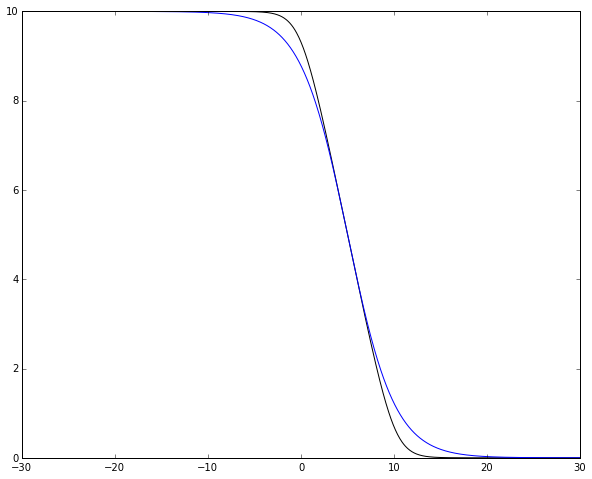

In [4]:
# testing the improved approximation
W = -10.0
alpha = 4*(2*sigmoid(W/2)-1)/W # this is the scaler that would match the slope at the 'midpoint'
phi = np.linspace(-30, 30, 1001)
plt.plot(phi, np.log(sigmoid(phi)/sigmoid(phi+W)),'k')
plt.plot(phi, -W*sigmoid(-alpha*(phi+W/2)),'b')
print(alpha)

## ELEPHANT IN THE ROOM

what a pain it is that, in order to update $h_j^A$, we need to find the input to each visible unit _in the case that $h_j^A = 0$. That really sucks. It'd be way way cooler if we could somehow just use the existing input to the visible unit, and perhaps account for the fact that $h_j^A \neq 0$ somehow..._

THIS IS A BIG FAT TODO.

## this looks like a pig, but perhaps can be found locally...

Building in the effect of the ACTUAL hidden unit activity $h_j^A$, we have that
$$
\begin{align}
\psi_j &= \psi_j^\text{RBM} \;\; + \;\; \sum_i W^A_{ji} \bigg[ \sigma(\phi^A_i - \hat{h}^A_j W^A_{ji}) - \sigma(\phi^{AB}_i - \hat{h}^A_j W^A_{ji}) \bigg] 
\end{align}
$$
where
   * $\phi^{A}_i $ is the actual input to visible unit $v_i$ arising from the $A$ net alone
   * $\phi^{AB}_i = \phi^{A}_i + \phi^{B}_i $ is the total input from both nets
   * $\hat{h}^A_j = h^A_j - 1/2$

The above was ignoring the "optimal gain" mentioned earlier.  
Let's denote the optimal gain as 
$\omega = 8\,(\sigma(W/2)-0.5)/W$:

$$
\begin{align}\psi_j &= \psi_j^\text{RBM} \;\; + \;\; \sum_i  W^A_{ji} \bigg[ \sigma\bigg(\phi^A_i \omega^A_{ji} \, - \, \hat{h}^A_j \omega^A_{ji} W^A_{ji}\bigg) \; - \; \sigma\bigg(\phi^{AB}_i \omega^A_{ji} \, - \, \hat{h}^A_j \omega^A_{ji} W^A_{ji} \bigg) \bigg] 
\end{align}
$$

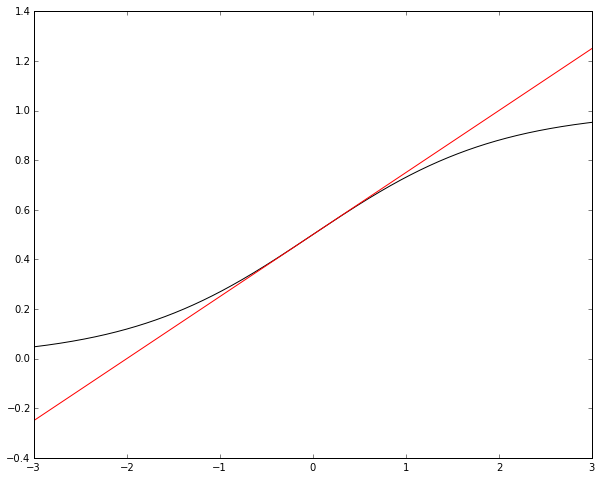

In [12]:
# testing 
phi = np.linspace(-3, 3, 1001)
plt.plot(phi, sigmoid(phi),'k')
plt.plot(phi, phi/4.+.5,'r')
#plt.axis('equal')

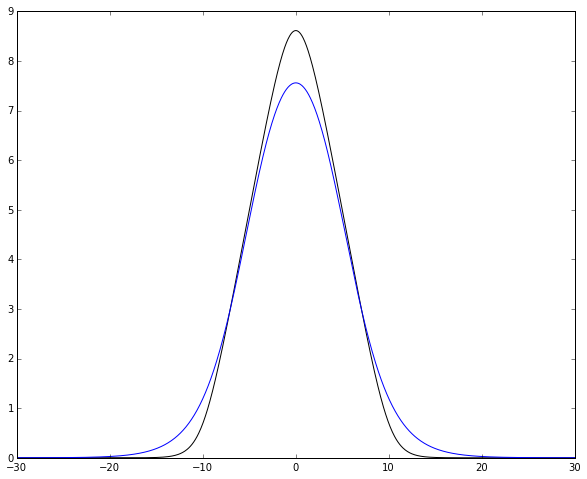

In [5]:
# Now to put the "eps" term in too, to see the entire approximation
eps = 10.0
truth = np.log(sigmoid(phi)/sigmoid(phi+W)) - np.log(sigmoid(phi+eps)/sigmoid(phi+W+eps))
approx = -W*(sigmoid(-alpha*(phi+W/2)) - sigmoid(-alpha*(phi+eps+W/2))   )
plt.plot(phi, truth,'k', phi, approx,'b')

# The learning algorithm
Stochastic ascent of the log likelihood.

SWITCHING NOTATION HERE IS A PAIN, BUT IT BECOMES MORE STRAIGHT-UP TO DITCH EPSILON AND INSTEAD PUT A/B SUPERSCIPTS ON PHI AND H, TO DENOTE THE TWO NETWORKS. NEED TO MAKE A DECISION ON WHICH IS BETTER AND USE IT EVERYWHERE I GUESS.

Handy shorthands:
   * $\phi_i^A = \sum_j h_j^A W_{ji}$, and similarly for $B$
   * $\phi_i^\text{AB} =  \phi_i^A + \phi_i^B$

We have that 
$$
\log P^\star(h^A, h^B, v) = \log P^\star(h^A) + \log P^\star(h^B) + \log P^\star(v \mid h^A, h^B)
$$

The first term is: 
$ \log P^\star(h^A) = \sum_i \log (1 + e^{\phi^A_i}) = -\sum_i \log (\sigma(\phi^A_i))$

Second is the same...

Third is 
$\sum_i v_i\log \sigma(\phi_i^\text{AB})  \; + \; (1-v_i) \log \sigma(- \phi_i^\text{AB}) $

So now we differentiate it w.r.t. some particular weight $W_{ml}^A$ like this:

First term:
$\frac{\partial}{\partial W_{ml}^A} \log P^\star(h^A)  = \sigma(\phi^A_l) h_m^A$ is the first term, which is just the average of the usual RBM Hebbian change.

The second term: is zero.

Third term: 

$\frac{\partial}{\partial W_{ml}^A} \log P^\star(v \mid h^A, h^B)   = (v_l-\sigma(\phi_l^\text{AB})) h_m^A$
which is "just the perceptron rool".

## so the learning algorithm is...

### WAKE PHASE

use our Gibbs chain to get samples from $h$ for each $v \in \mathcal{D}$, and do

$\Delta W_{ji}^A \;\;\; \propto \;\;\; \underbrace{\sigma(\phi^A_i) h_j^A}_\text{mean field Hebbian} \; + \; \underbrace{(v_i - \sigma(\phi_i^\text{AB})) h_j^A}_\text{Perceptron learning rule}$

and similarly for the other RBM. Note that the $\phi$'s are not the same in the two terms: the first only sums input from the A side, but the second sums from both hidden layers.

Another way to say the same thing would be

$\Delta W_{ji}^A \;\;\; \propto \;\;\; \big[ v_i \, + \, \sigma(\phi^A_i) \, - \,\sigma(\phi_i^\text{AB}) \big] h_j^A$

which is like a Hebbian update but with a modified visible activation, in effect.

_Q: What do we make of the resemblance between this and the approximation, below?_


### SLEEP PHASE 
use "regular" Gibbs sampling _in each model separately_ to sample independently from the two RBMs, and do

$\Delta W_{ji}^A \;\;\; \propto \;\;\; - \sigma( \phi^{A}_i) \; h_j^A$

and similarly for the other RBM.

### notice the free phase is free
In the FREE PHASE the expected $\psi$ is simply:
$$\bar{\psi}_j = \sum_i W_{ji} \sigma_{\phi}$$
Does that mean that the free phase in this model corresponds to what it would be if the two RBMs were not even connected?
Looks like it (although this is just an approximation, isn't it?).
BUT OF COURSE IT DOES! In the "unrolled" version of the net, the visibles are not clamped in the free phase and hence there's no explaining away going on between the two RBMs: they're independent RBMs doing their own thing, in the free phase. It's *only the wake phase that needs any update to the vanilla Gibbs* $\psi$.

Thought: maybe even the wake phase could be implemented via samples instead of having to calculate and propogate those sigmoid floats? THINK ABOUT THIS SOME MORE.

In [ ]:
import sympy as sp
x,y,z = sp.symbols('x y z')
sp.simplify(sp.log( (1+sp.exp(-x-y)) * (1+sp.exp(x+y+z)) / (1+sp.exp(-x-y-z)) / (1+sp.exp(x+y))) )
sp.simplify(sp.log( (1+sp.exp(x)) * (1+sp.exp(x+y+z)) / (1+sp.exp(x+y)) / (1+sp.exp(x+z)) )) 